In [1]:
import warnings
import os
import gc
import timm
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, RandomRotation, RandomHorizontalFlip, ToTensor, Resize
from tqdm import tqdm
from pathlib import Path

In [2]:
# Ignore warnings and configure memory management
warnings.filterwarnings("ignore")  # Ignore warnings during execution
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  # Prevent memory fragmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Load and prepare data
def load_data(data_path):
    file_names, labels = [], []
    for file in tqdm(sorted(Path(data_path).glob('*/*.*'))):
        file_names.append(str(file))
        label = ' '.join(str(file).split('/')[-2].split('_')[:2])
        labels.append(label)
    
    df = pd.DataFrame({"image": file_names, "label": labels})
    
    # Random oversampling of all minority classes
    y = df[['label']]
    df = df.drop(['label'], axis=1)
    ros = RandomOverSampler(random_state=83)
    df, y_resampled = ros.fit_resample(df, y)
    df['label'] = y_resampled
    gc.collect()
    
    return df


In [4]:
# Create Dataset
def create_dataset(df):
    dataset = Dataset.from_pandas(df).cast_column("image", Image())
    
    # Create label mappings
    labels_list = sorted(list(set(df['label'])))
    label2id = {label: i for i, label in enumerate(labels_list)}
    id2label = {i: label for i, label in enumerate(labels_list)}
    
    ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
    
    def map_label2id(example):
        example['label'] = ClassLabels.str2int(example['label'])
        return example
    
    dataset = dataset.map(map_label2id, batched=True)
    dataset = dataset.cast_column('label', ClassLabels)
    dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
    
    return dataset, label2id

In [5]:
# Image processing
def get_transforms(size):
    normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_transforms = Compose([
        Resize((size, size)),
        RandomRotation(20),
        RandomHorizontalFlip(0.5),
        ToTensor(),  # Ensure image is converted to tensor
        normalize
    ])

    val_transforms = Compose([
        Resize((size, size)),
        ToTensor(),  # Ensure image is converted to tensor
        normalize
    ])
    
    return train_transforms, val_transforms

In [6]:
# Apply transformations
def apply_transforms(dataset, train_transforms, val_transforms):
    def train_transforms_func(examples):
        examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    def val_transforms_func(examples):
        examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
        return examples

    dataset['train'].set_transform(train_transforms_func)
    dataset['test'].set_transform(val_transforms_func)

In [7]:
# DataLoader
def create_data_loader(dataset, batch_size):
    def collate_fn(batch):
        return {
            'pixel_values': torch.stack([b['pixel_values'] for b in batch]),
            'label': torch.tensor([b['label'] for b in batch])
        }
    
    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(dataset['test'], batch_size=batch_size // 2, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, test_loader

In [8]:
# Model training
def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader):
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return train_loss_history, train_acc_history

In [9]:
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred

In [10]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [11]:
# Plot training history
def plot_training_history(loss_history, acc_history):
    epochs = range(1, len(loss_history) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, label='Training Accuracy', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
# Save the model
def save_model(model, model_path):
    torch.save(model.state_dict(), model_path)

100%|██████████████████████████████████████████████████| 9630/9630 [00:00<00:00, 507413.73it/s]


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

100%|████████████████████████████████████████████████████████| 750/750 [08:43<00:00,  1.43it/s]


Epoch [1/30], Loss: 0.0091, Accuracy: 0.9968


100%|████████████████████████████████████████████████████████| 750/750 [08:52<00:00,  1.41it/s]


Epoch [2/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████████| 750/750 [08:44<00:00,  1.43it/s]


Epoch [3/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████████| 750/750 [08:36<00:00,  1.45it/s]


Epoch [4/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████████| 750/750 [11:53<00:00,  1.05it/s]


Epoch [5/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [09:34<00:00,  1.30it/s]


Epoch [6/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:46<00:00,  1.43it/s]


Epoch [7/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:37<00:00,  1.45it/s]


Epoch [8/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [9/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [10/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [11/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [12/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [13/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [14/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [15/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [16/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [17/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [18/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [19/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [20/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [21/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [22/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [23/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:29<00:00,  1.47it/s]


Epoch [24/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [25/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.48it/s]


Epoch [26/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:27<00:00,  1.48it/s]


Epoch [27/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:28<00:00,  1.47it/s]


Epoch [28/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:27<00:00,  1.48it/s]


Epoch [29/30], Loss: 0.0000, Accuracy: 1.0000


100%|████████████████████████████████████████████████████| 750/750 [08:27<00:00,  1.48it/s]


Epoch [30/30], Loss: 0.0000, Accuracy: 1.0000
Accuracy: 1.0000
F1 Score: 1.0000


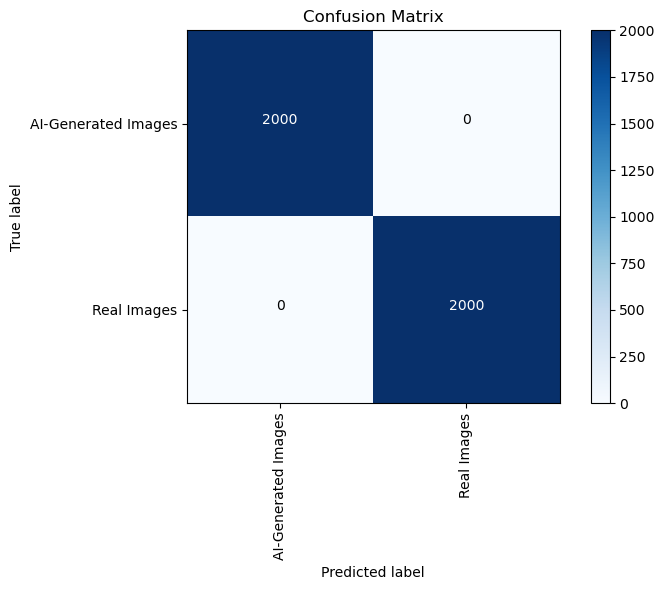


Classification report:

                     precision    recall  f1-score   support

AI-Generated Images     1.0000    1.0000    1.0000      2000
        Real Images     1.0000    1.0000    1.0000      2000

           accuracy                         1.0000      4000
          macro avg     1.0000    1.0000    1.0000      4000
       weighted avg     1.0000    1.0000    1.0000      4000



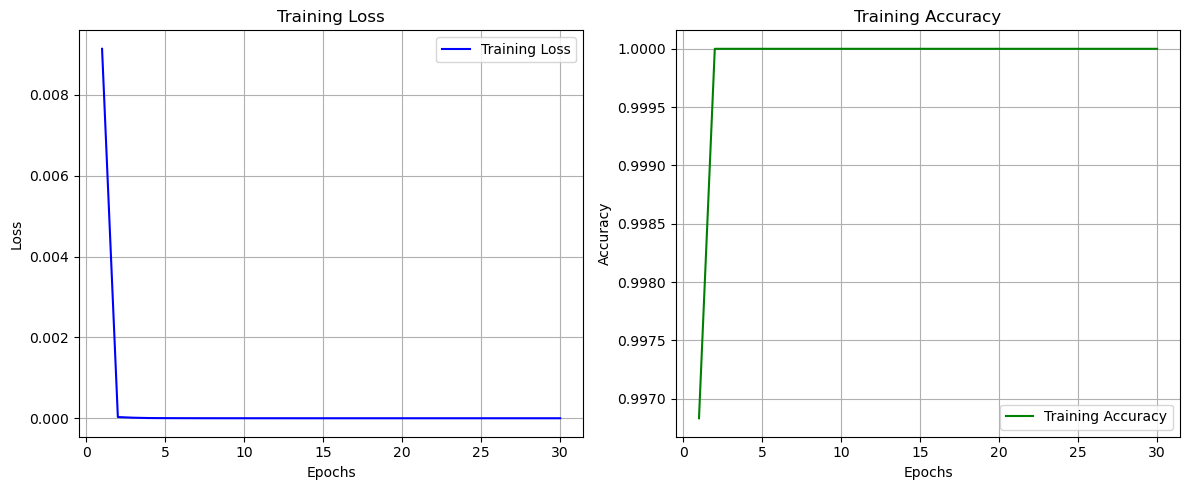

In [13]:
# Main execution
if __name__ == "__main__":
    # Load data
    data_path = '../input/Human Faces Dataset/'
    df = load_data(data_path)
    
    # Create dataset and label mapping
    dataset, label2id = create_dataset(df)
    
    # Get image transformations
    _train_transforms, _val_transforms = get_transforms(size=384)

    # Apply transformations
    apply_transforms(dataset, _train_transforms, _val_transforms)

    # Create DataLoader
    train_loader, test_loader = create_data_loader(dataset, batch_size=8)

    # Load, train, and evaluate model using timm
    model = timm.create_model('vit_base_r50_s16_384', pretrained=True, num_classes=len(label2id))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)  # 将模型移动到设备上

    # Train the model
    train_loss_history, train_acc_history = train(model, train_loader, optimizer, criterion, num_epochs=30)

    # Evaluate the model
    y_true, y_pred = evaluate(model, test_loader)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    if len(label2id) <= 120:
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, list(label2id.keys()), figsize=(8, 6))

    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=list(label2id.keys()), digits=4))
    # Plot training loss and accuracy
    plot_training_history(train_loss_history, train_acc_history)

    # Save the model
    save_model(model, '../output/vit_base_r50_s16_384.pth')